# Image classification

_Programming PyTorch for Deep Learning: Creating and Deploying Deep Learning Applications_

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [2]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [3]:
img_size = 64
img_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

In [4]:
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)

In [5]:
val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

In [6]:
test_data_path = "./test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms, is_valid_file=check_image) 

In [7]:
batch_size=64

In [8]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle = True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle = True) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle = True) 

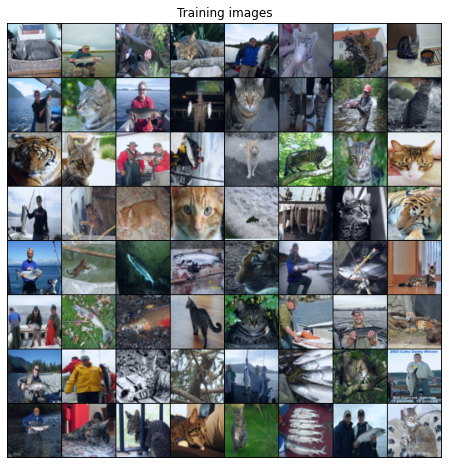

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils

sample_batch = next(iter(train_data_loader))
plt.figure(figsize=(10,8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0],padding=1,normalize = True),(1,2,0)));

## Build a simple neural network

In [27]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
simplenet = SimpleNet()

## optimizer

In [29]:
lr = .001
optimizer = optim.Adam(simplenet.parameters(), lr=lr)

In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

## Training 

In [31]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)

        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [32]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, device=device)

Epoch: 1, Training Loss: 0.65, Validation Loss: 0.56, accuracy = 0.74
Epoch: 2, Training Loss: 0.44, Validation Loss: 0.57, accuracy = 0.72
Epoch: 3, Training Loss: 0.33, Validation Loss: 0.68, accuracy = 0.68
Epoch: 4, Training Loss: 0.24, Validation Loss: 0.57, accuracy = 0.72
Epoch: 5, Training Loss: 0.16, Validation Loss: 0.60, accuracy = 0.75


## Predictions

 `cat` will be 0, `fish` will be 1.

In [21]:
labels = ['cat','fish']

img = Image.open("./val/fish/100_1422.JPG") 
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

simplenet.eval()
prediction = F.softmax(simplenet(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 

fish


## Saving Models

In [22]:
torch.save(simplenet, "/tmp/simplenet") 
simplenet = torch.load("/tmp/simplenet")    


In [23]:
torch.save(simplenet.state_dict(), "/tmp/simplenet")    
simplenet = SimpleNet()
simplenet_state_dict = torch.load("/tmp/simplenet")
simplenet.load_state_dict(simplenet_state_dict)   

<All keys matched successfully>